# Scaling Raw Jets with Coffea Processor

In [1]:
import awkward as ak
import numpy as np
import coffea
import uproot
import hist
import vector
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from dask.distributed import Client
import matplotlib.pyplot as plt
from distributed.diagnostics.plugin import UploadDirectory
from collections import defaultdict
import correctionlib
from coffea.analysis_tools import PackedSelection
import pickle
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

The purpose of this notebook is to automate the analysis we did in `raw_jets.ipynb`, and apply it to a data set. For example, the `flatPU_JMENano_20XX.txt` files correpsonding to the 2016, 2017, and 2018 eras have $23$, $52$, and $42$ ROOT files respectively, so we are analysing $117$ ROOT files altogether. This analysis can be streamlined and made more efficient by utilizing the Coffea processor class. The basic details of this class are summarized as follows:

* `__init__`: Axes and histogram objects are defined here and gatherered (i.e. accumulated) in a dictionary.
* `accumulator`: Helper method that returns the accumulated histograms.
* `process`: Physics analysis and histogram-filling takes place here.
* `postprocess`: Here we can make any post-analysis adjustments such as a rebinning or rescaling.

Note that most our code has been recycled into our processor; this is one of the many advantages of scaling up our analysis. Documentation for Coffea can be found here [**[1]**](https://coffea-casa.readthedocs.io/en/latest/).

In [2]:
class RawProcessor(processor.ProcessorABC):
        
    def __init__(self):
        
        dataset_axis = hist.axis.StrCategory([], growth=True, name="dataset", label="Primary dataset")
        eta_axis = hist.axis.Regular(100, -8.1, 8.1, name="eta", label="$\eta$")
        phi_axis = hist.axis.Regular(100, -2*np.pi, 2*np.pi, name="phi", label="$\phi$")
        pt_axis = hist.axis.Regular(500, 0, 13500, name="pt", label="$p_T$")
        
        rho_axis = hist.axis.Regular(100, 0, 101, name="rho", label=r"$\rho$")
        npvs_axis = hist.axis.Regular(190, 0, 191, name="npvs", label="$N_{PV}$")
        npu_axis = hist.axis.Regular(60, 0, 120, name="npu", label="$N_{PU}$")
        
        h_gen_jets_hist = hist.Hist(dataset_axis, eta_axis, phi_axis, pt_axis)
        h_reco_jets_hist = hist.Hist(dataset_axis, eta_axis, phi_axis, pt_axis)
        h_corrections_histogram = hist.Hist(dataset_axis, rho_axis, npvs_axis, npu_axis)     
                                         
        cutflow = {}
        
        self.hists = {
            "gen_jets_hist":h_gen_jets_hist,
            "reco_jets_hist":h_reco_jets_hist,
            "corrections_histogram":h_corrections_histogram,
            "cutflow":cutflow,
        }         
        
    @property
    def accumulator(self):
        return self.hists
    
    def process(self, events):
        
        dataset = events.metadata['dataset']
        print(f"Processing ----- {dataset}")
        if dataset not in self.hists["cutflow"]:
            self.hists["cutflow"][dataset] = defaultdict(int)
            
        gen_jets = events.GenJet
        reco_jets = events.Jet
        reco_rho = events.fixedGridRhoFastjetAll
        n_reco_vtx = events.PV.npvs 
        n_pileup = events.Pileup.nPU 
        pu_nTrueInt = events.Pileup.nTrueInt
        
        self.hists["gen_jets_hist"].fill(dataset=dataset, eta=ak.ravel(gen_jets.eta), phi=ak.ravel(gen_jets.phi), pt=ak.ravel(gen_jets.pt))
        self.hists["reco_jets_hist"].fill(dataset=dataset, eta=ak.ravel(reco_jets.eta), phi=ak.ravel(reco_jets.phi), pt=ak.ravel(reco_jets.pt))
        self.hists["corrections_histogram"].fill(dataset=dataset, rho=ak.ravel(reco_rho), npvs=ak.ravel(n_reco_vtx), npu=ak.ravel(n_pileup))  
            
        return self.hists
    
    def postprocess(self, accumulator):
        return accumulator

With our processor defined, our next step is to provide it with a set of sample files and run the code. To do so, we can use the `processor.Runner` method which requires the following arguments:

* `fileset`: Dictionary of files, where the keys are usually the datasets, and the values are lists of ROOT files.
* `treename`: TTree inside the ROOT file that our analysis will use as base.
* `executor`: Executor to run the analysis. Some examples are:  
    * `IterativeExecutor`: Execute in one thread iteratively.
    * `FuturesExecutor`: Execute using multiple local cores using python futures.
    * `DaskExecutor`: Execute using dask futures - requires defining a client such as `client = Client("tls://localhost:8786")` to connect to the Dask scheduler. 
* `executor_args`: Optional arguments to pass to our runner. Among the most important one is the `schema` specification.  
* `chunksize` `maxchunks`: Number of chunks data will be split into. For example, if our data has $1,000,000$ events and we set `chunksize=250000`, our data will be split into four chunks.

We will create a a fileset dictionary that matches each ROOT file to its era, and then pass this dictionary to our runner. Lastly, we will save all of our content to a .pkl file for future analysis.

In [3]:
#prependstr = "root://cmsxrootd.fnal.gov/"
prependstr = "root://xcache/"

filedir = "samples/"

filestr = "flatPU_JMENano_%s.txt"

eras = ['2016', '2017', '2018']

fileset = {}

for era in eras:
    filename = filedir + filestr % (era)
    with open(filename) as f:
        files = [prependstr + i.rstrip() for i in f.readlines() if i[0] != "#"]
        fileset[era] = files
        
futures_run = processor.Runner(
    executor=processor.FuturesExecutor(compression=None, workers=4),
    schema=NanoAODSchema,
    maxchunks=10,
    skipbadfiles=True,
)

out = futures_run(
    fileset=fileset,
    treename="Events",
    processor_instance=RawProcessor()
)

fname_out = "pkl_files/raw_jets.pkl"

with open(fname_out, "wb") as f:
    pickle.dump(out, f)

Output()

Output()

Processing ----- 2018Processing ----- 2018

Processing ----- 2018
Processing ----- 2018
Processing ----- 2018
Processing ----- 2018
Processing ----- 2018
Processing ----- 2018
Processing ----- 2018
Processing ----- 2018
Processing ----- 2017
Processing ----- 2017
Processing ----- 2017
Processing ----- 2017
Processing ----- 2017
Processing ----- 2017
Processing ----- 2017
Processing ----- 2017
Processing ----- 2017
Processing ----- 2017
Processing ----- 2016
Processing ----- 2016
Processing ----- 2016Processing ----- 2016

Processing ----- 2016
Processing ----- 2016
Processing ----- 2016
Processing ----- 2016
Processing ----- 2016
Processing ----- 2016


The last thing we can do is open our pickle file, and view all its histograms. The process for producing histograms is then the same as before; we give plots for the distributions of all jet kinematic variables and pileup observables across all three eras, for both MC generated and reconstructed jets. 

In [4]:
with open("pkl_files/raw_jets.pkl", "rb") as f:
    out = pickle.load(f)
    
for k,v in out.items():
    print(k)
    #print(f"{v}\n")

gen_jets_hist
reco_jets_hist
corrections_histogram
cutflow


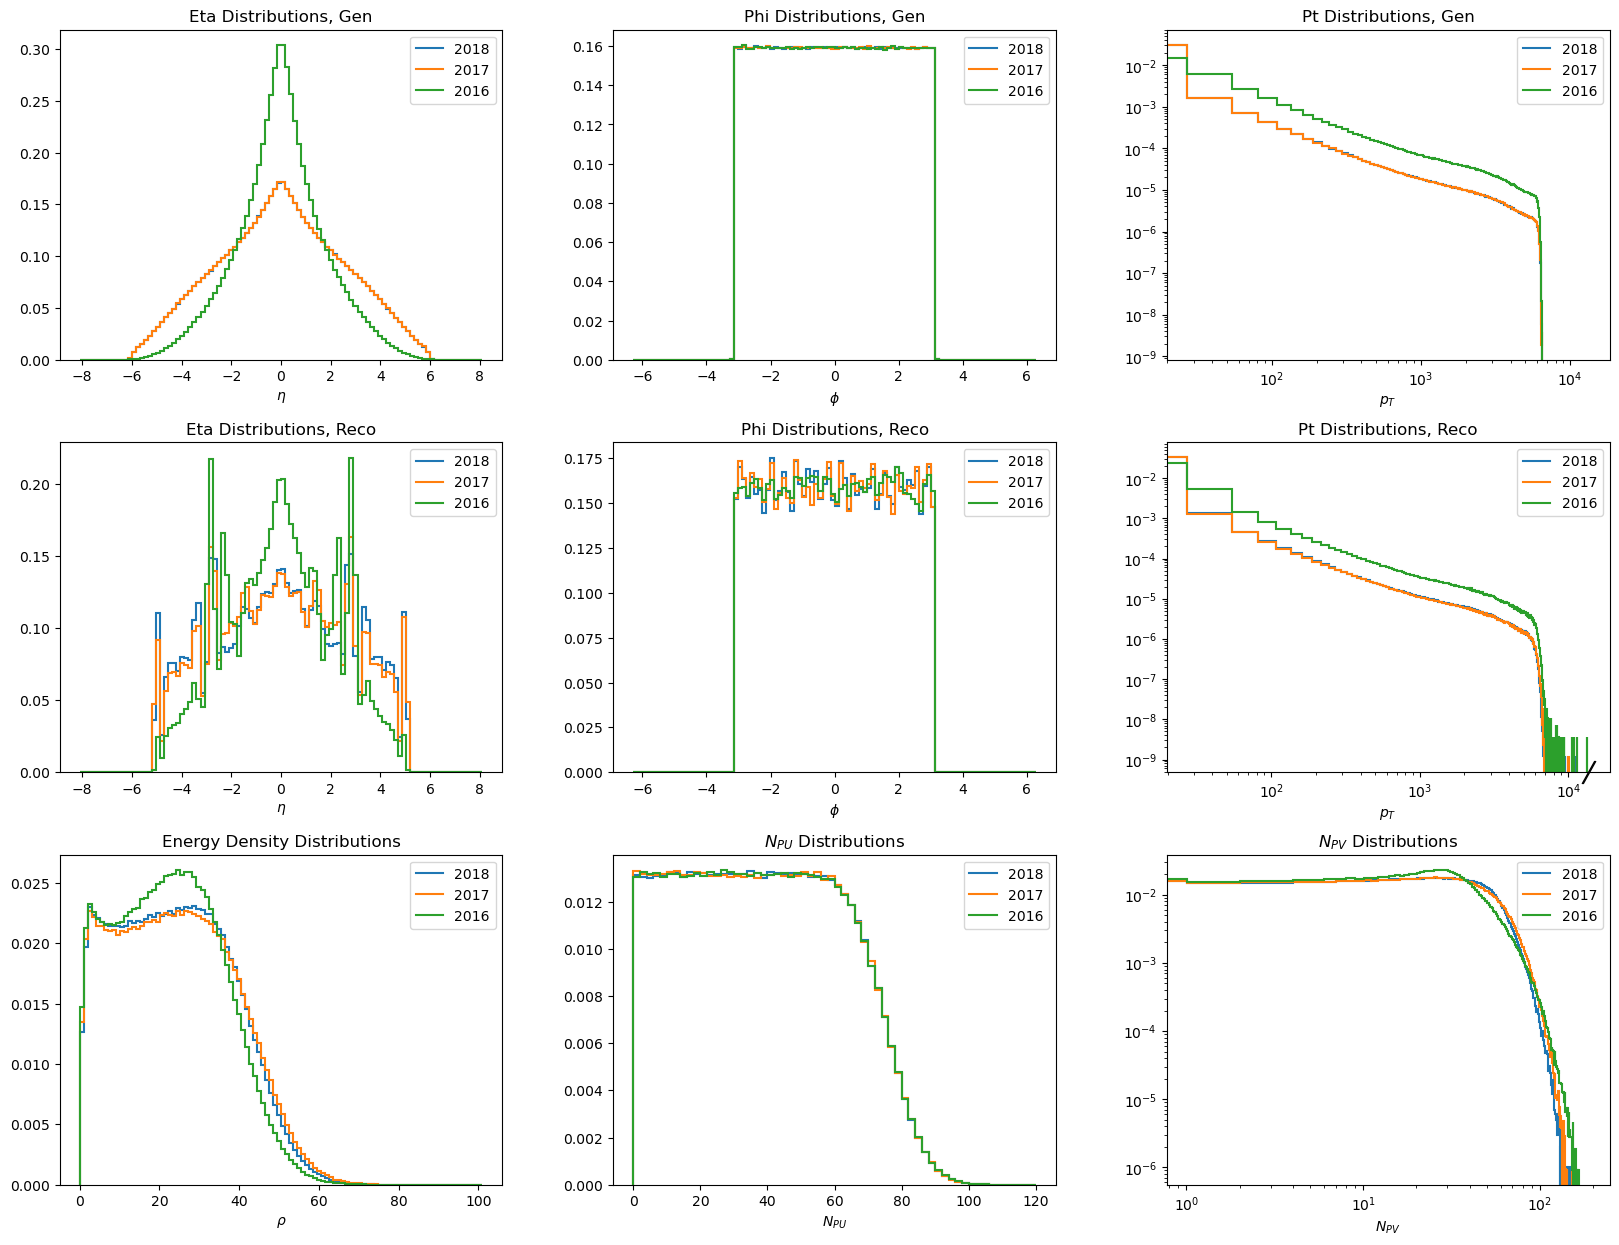

In [5]:
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
plt.subplots_adjust(hspace=0.25, wspace=0.25)

out['gen_jets_hist'].project('dataset', 'eta').plot(density=True, ax=axs[0, 0])
out['gen_jets_hist'].project('dataset', 'phi').plot(density=True, ax=axs[0, 1])
out['gen_jets_hist'].project('dataset', 'pt').plot(density=True, ax=axs[0, 2])

out['reco_jets_hist'].project('dataset', 'eta').plot(density=True, ax=axs[1, 0])
out['reco_jets_hist'].project('dataset', 'phi').plot(density=True, ax=axs[1, 1])
out['reco_jets_hist'].project('dataset', 'pt').plot(density=True, ax=axs[1, 2])

out['corrections_histogram'].project("dataset", "rho").plot(density=True, ax=axs[2, 0])
out['corrections_histogram'].project('dataset', 'npu').plot(density=True, ax=axs[2, 1])
out['corrections_histogram'].project('dataset', 'npvs').plot(density=True, ax=axs[2, 2])

axs[0, 0].set_title("Eta Distributions, Gen")
axs[0, 0].legend()
axs[0, 1].set_title("Phi Distributions, Gen")
axs[0, 1].legend()
axs[0, 2].set_title("Pt Distributions, Gen")
axs[0, 2].set_yscale('log')
axs[0, 2].set_xscale('log')
axs[0, 2].legend()

axs[1, 0].set_title("Eta Distributions, Reco")
axs[1, 0].legend()
axs[1, 1].set_title("Phi Distributions, Reco")
axs[1, 1].legend()
axs[1, 2].set_title("Pt Distributions, Reco")
axs[1, 2].set_yscale('log')
axs[1, 2].set_xscale('log')
axs[1, 2].legend()

axs[2, 0].set_title("Energy Density Distributions")
axs[2, 0].legend()
axs[2, 1].set_title("$N_{PU}$ Distributions")
axs[2, 1].legend()
axs[2, 2].set_title("$N_{PV}$ Distributions")
axs[2, 2].set_yscale('log')
axs[2, 2].set_xscale('log')
axs[2, 2].legend()
plt.show()